In [1]:
# from CASBI.generator.fff.fff_model import *
from CASBI.generator.fff.fff_model import FreeFormFlow

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon as js_div
import ndtest
import torch

from tqdm.notebook import tqdm

In [2]:
def get_even_space_sample(df_mass_masked):
    '''
    Given a dataframe of galaxy in a range of mass, it returns 10 equally infall time spaced samples  
    '''
    len_infall_time = len(df_mass_masked['infall_time'].unique())
    index_val_time = np.linspace(0, len_infall_time-1, 30)
    time = np.sort(df_mass_masked['infall_time'].unique())[index_val_time.astype(int)]
    for i, t in enumerate(time):
        temp = df_mass_masked[df_mass_masked['infall_time']==t]
        galaxy_temp = temp.sample(1)['Galaxy_name'].values[0]
        if i == 0:
            df_time = df_mass_masked[df_mass_masked['Galaxy_name']==galaxy_temp]
        else:  
            df_galaxy = df_mass_masked[df_mass_masked['Galaxy_name']==galaxy_temp]
            df_time = pd.concat([df_time, df_galaxy], ignore_index=True)
    return df_time
    
    
def load_train_objs(path_train_dataframe:str):
    train_set = pd.read_parquet(path_train_dataframe)
    train_set =  train_set.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
    
    low_percentile_mass, high_percentile_mass = np.percentile(train_set['star_log10mass'], 25), np.percentile(train_set['star_log10mass'], 75)
    low_mass = get_even_space_sample(train_set[train_set['star_log10mass']<=low_percentile_mass])
    intermediate_mass= get_even_space_sample(train_set[(train_set['star_log10mass']>low_percentile_mass) & (train_set['star_log10mass']<high_percentile_mass)])
    high_mass = get_even_space_sample(train_set[train_set['star_log10mass']>=high_percentile_mass])
    val_set = pd.concat([low_mass, intermediate_mass, high_mass])
    train_set = train_set[~train_set['Galaxy_name'].isin(val_set['Galaxy_name'])]
    
    low_percentile_mass, high_percentile_mass = np.percentile(train_set['star_log10mass'], 25), np.percentile(train_set['star_log10mass'], 75)
    low_mass = get_even_space_sample(train_set[train_set['star_log10mass']<=low_percentile_mass])
    intermediate_mass = get_even_space_sample(train_set[(train_set['star_log10mass']>low_percentile_mass) & (train_set['star_log10mass']<high_percentile_mass)])
    high_mass = get_even_space_sample(train_set[train_set['star_log10mass']>=high_percentile_mass])
    test_set = pd.concat([low_mass, intermediate_mass, high_mass])
    test_set.to_parquet(f'./test_data.parquet')
    
    train_set = train_set[~train_set['Galaxy_name'].isin(test_set['Galaxy_name'])]
    
    #remove the column Galaxy name before passing it to the model
    test_set = test_set[train_set.columns.difference(['Galaxy_name'], sort=False)]
    train_set = train_set[train_set.columns.difference(['Galaxy_name'], sort=False)]
    val_set = val_set[train_set.columns.difference(['Galaxy_name'], sort=False)]
    test_set = torch.from_numpy(np.array(test_set.values, dtype=float))
    val_set = torch.from_numpy(np.array(val_set.values, dtype=float))
    train_set = torch.from_numpy(np.array(train_set.values, dtype=float))
    
    return train_set, val_set

train_set, val_set = load_train_objs('../../data/dataframe/dataframe.parquet')

KeyboardInterrupt: 

In [3]:
Flow = FreeFormFlow(dim = 2, 
                    cond_dim = 6,
                    hidden_dim = 128,
                    latent_dim = 2,
                    n_SC_layer = 6,
                    beta = 100*2,
                    device = 'cuda'
                    )

In [4]:
# Flow.train_model(n_epochs = 5,
#                  batch_size=1024,
#                  optimizer=torch.optim.Adam(Flow.parameters(), lr=2e-4),
#                  train_set=train_set,
#                  val_set=val_set)

# Flow.load_state_dict(torch.load('./best_snapshot.pth'))
Flow.load_state_dict(torch.load('./snapshot.pth'))

<All keys matched successfully>

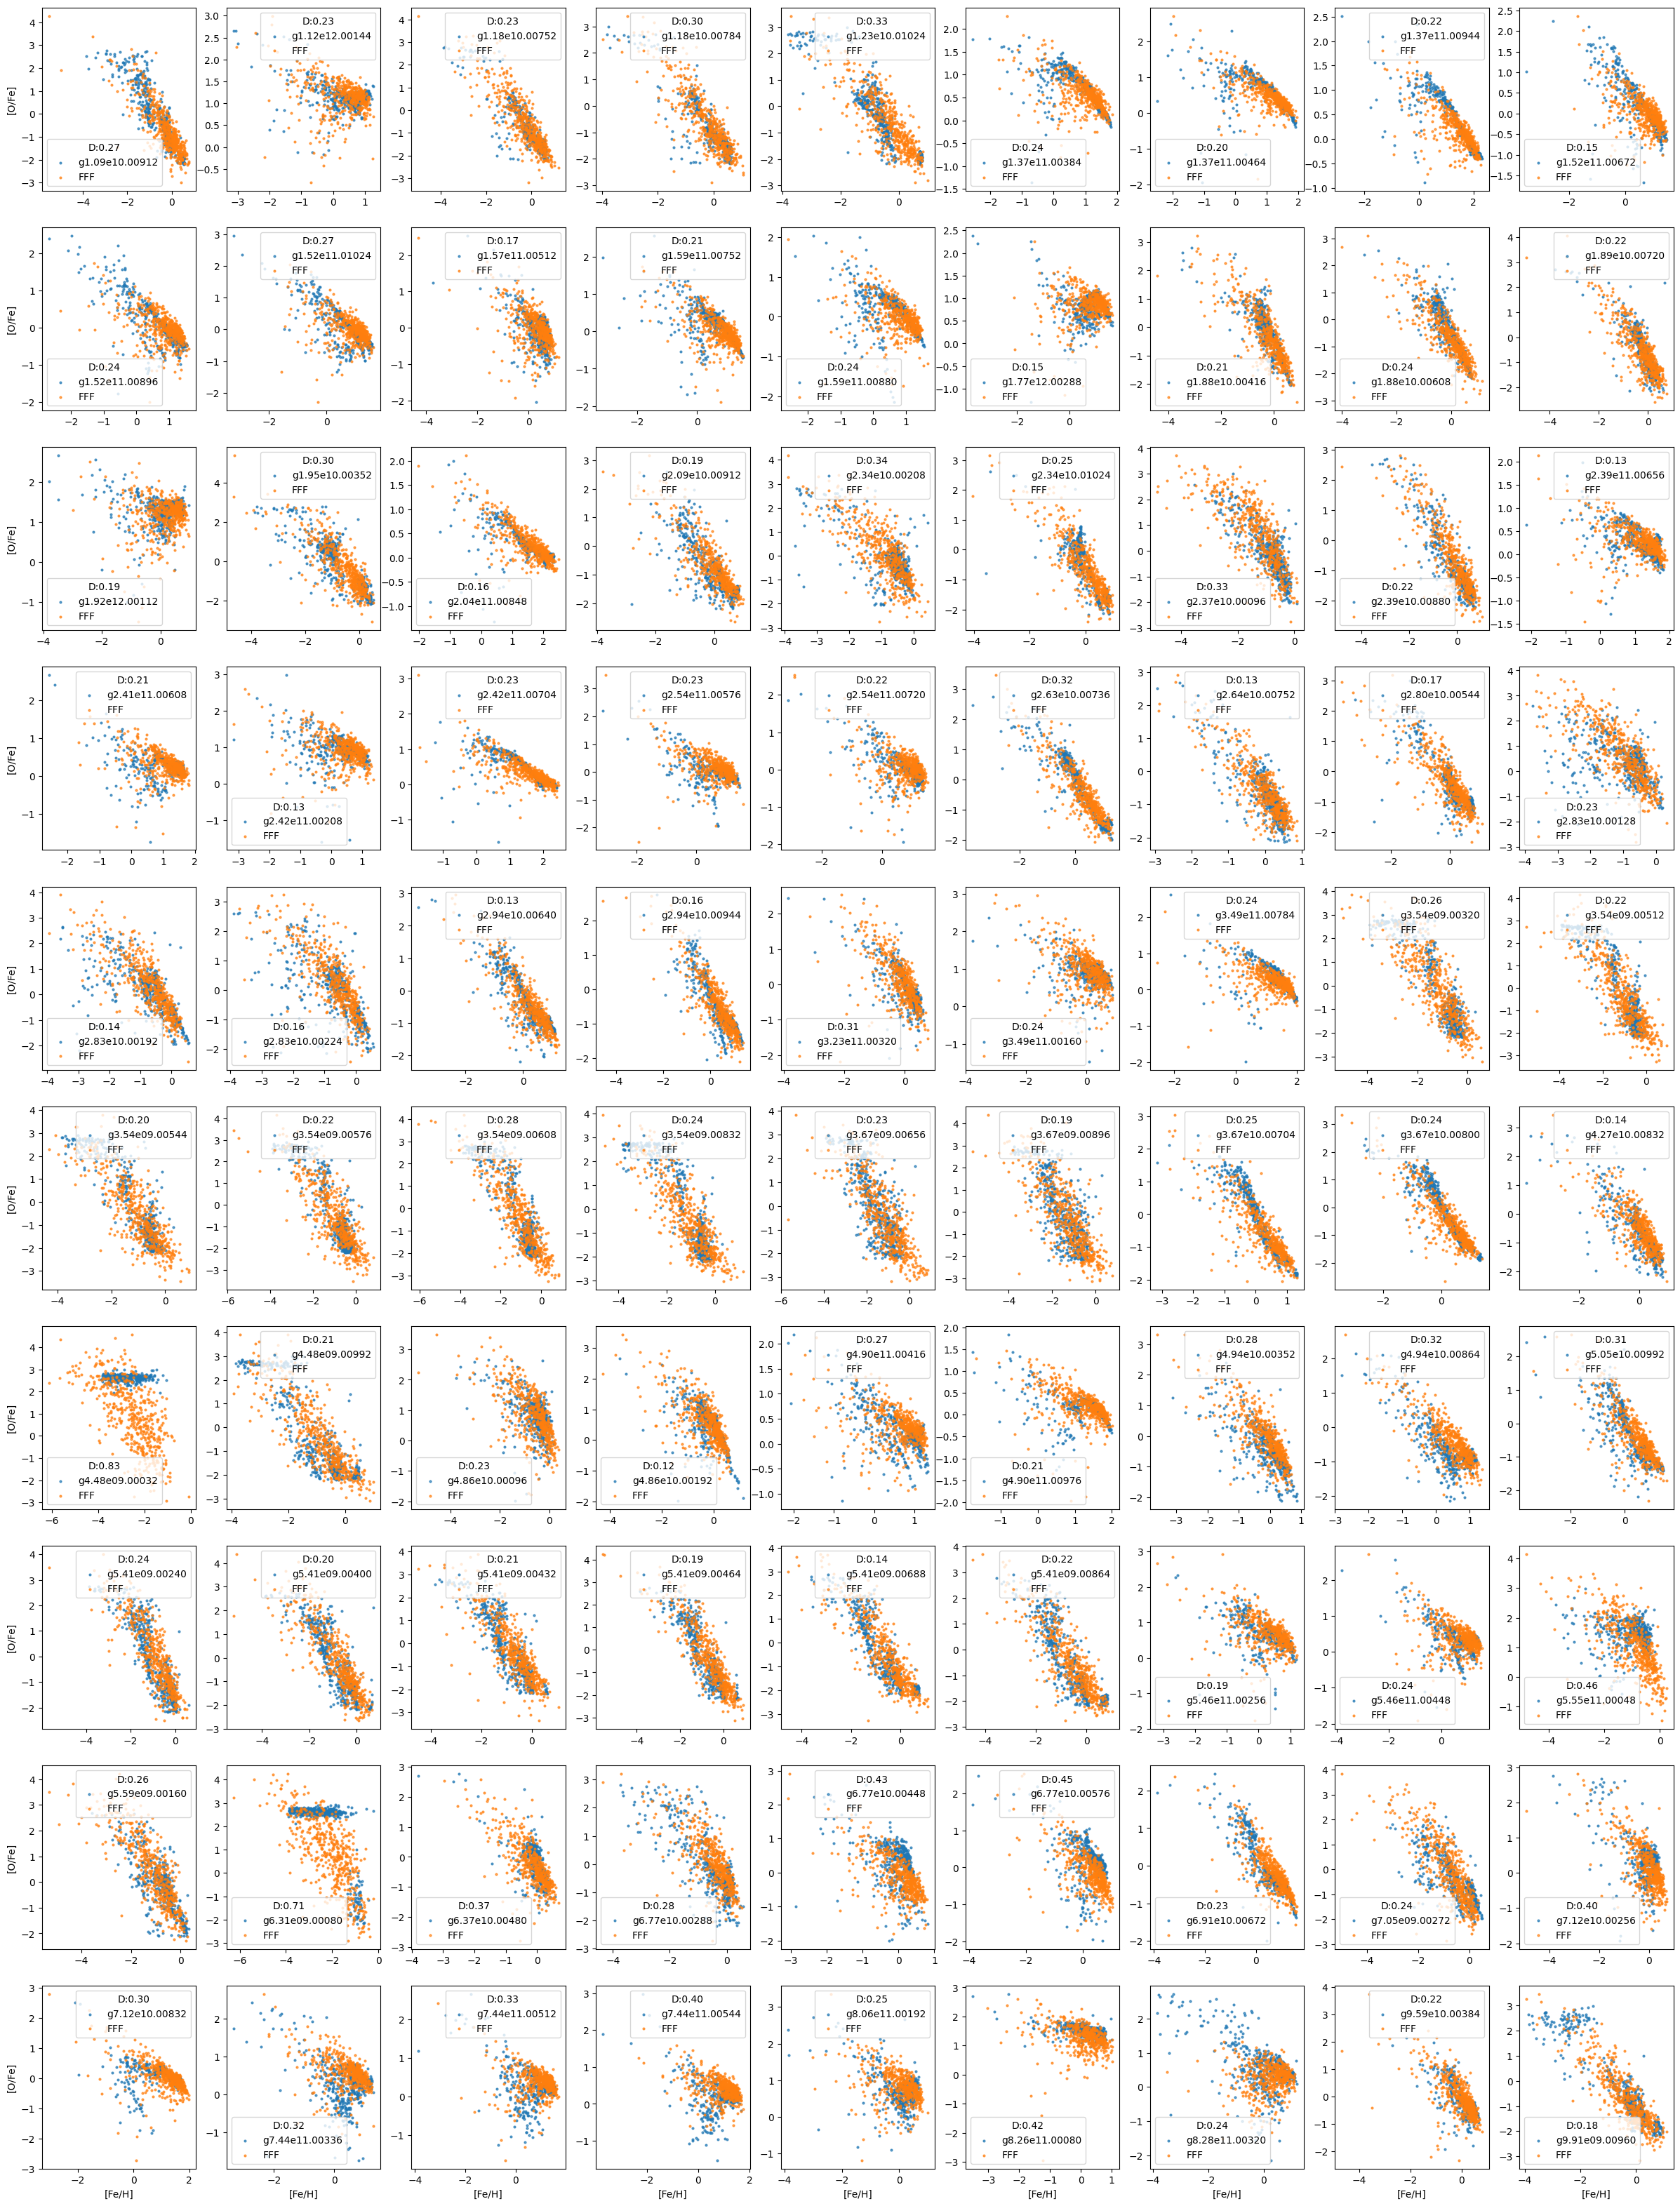

In [5]:
test_data = pd.read_parquet('./test_data.parquet')
fig = plt.figure(figsize=(30, 40))
plot_kwargs = dict(
        s=4,
        alpha=.7)

D_list = []
for i, galaxy in enumerate(sorted(test_data['Galaxy_name'].unique())):
    ax = fig.add_subplot(10, 9, i+1)
    plot_data = test_data[test_data['Galaxy_name']==galaxy]
    ax.scatter(x=plot_data['feh'], y=plot_data['ofe'], label=f"{galaxy}", **plot_kwargs)

    with torch.no_grad():
        Flow.eval()
        cond = torch.from_numpy(plot_data.drop(['feh', 'ofe', 'Galaxy_name'], axis=1).values[0, :]).float().to(Flow.device)
        cond = cond.repeat(500, 1)
        samples = Flow.sample(n_samples=500, cond=cond).cpu().T
        ax.scatter(*samples, label="FFF", **plot_kwargs)
        
    samples = samples.T.numpy().astype(float)
    P, D = ndtest.ks2d2s(plot_data['feh'].values, plot_data['ofe'].values, samples[:, 0], samples[:, 1], extra=True)
    D_list.append(D)
    
    ax.legend(title=f"D:{D:.2f}")
    if i > 80:
        ax.set_xlabel('[Fe/H]')
    
    if i % 9 == 0:
        ax.set_ylabel('[O/Fe]')

Text(0.5, 0, 'D')

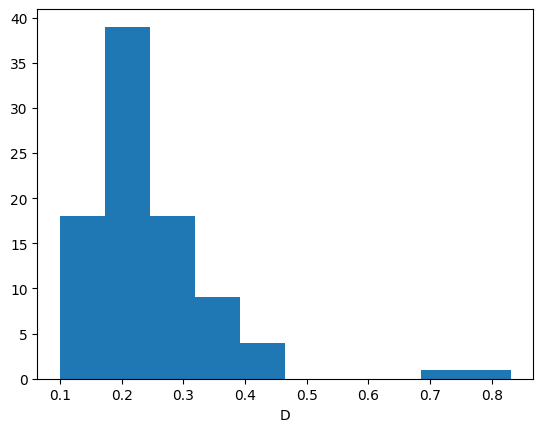

In [6]:
plt.hist(D_list, )
plt.xlabel('D')

In [6]:
def create_sample_df(df_to_sample, Flow):
    
    other_cols = df_to_sample.columns.difference(['Galaxy_name'])
    df = pd.DataFrame(columns=df_to_sample.columns)
    with torch.no_grad():
        Flow.eval()
        for galaxy in sorted(df_to_sample['Galaxy_name'].unique()):    
            galaxy_data = df_to_sample[df_to_sample['Galaxy_name']==galaxy]
            cond = torch.from_numpy(galaxy_data.drop(['feh', 'ofe', 'Galaxy_name'], axis=1).values[0, :]).float().to(Flow.device)
            cond = cond.repeat(500, 1)
            samples = Flow.sample(n_samples=500, cond=cond).cpu()
            generated_data = pd.DataFrame(samples, columns=['feh', 'ofe'])
            for col in galaxy_data.columns[2:]:
                generated_data[col] = galaxy_data[col].values[0]
            generated_data['Galaxy_name'] = galaxy
            df = pd.concat([df, generated_data])
    return df

sample_df = create_sample_df(test_data, Flow)

/tmp/ipykernel_18819/938325085.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, generated_data])


  0%|          | 0/90 [00:00<?, ?it/s]

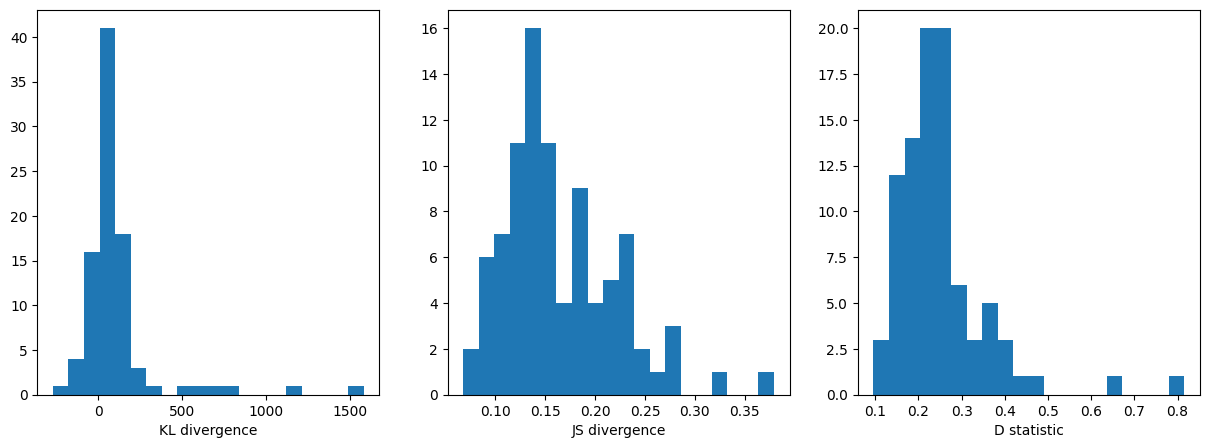

In [10]:
def kl_divergence(p, q):
 return sum(p[i] * np.log2(p[i]/q[i]) if q[i]!=0 else 0 for i in range(len(p)))

def get_test_metric(test_df:pd.DataFrame, df_sample, model:torch.nn.Module, inverse=False, inverse_rescale_file=None):
    """
    Return the KL and JS divergence between the KDE of the true data and the generated data for the test set.
    
    Parameters
    ----------
    test_df : pd.DataFrame
        The test set dataframe.
    
    model: torch.nn.Module
        The model used to generate the data.
    
    Returns
    -------
    kl_div_value : float
        The KL divergence between the KDE of the true data and the generated data.
    js_div_value : float
        The JS divergence between the KDE of the true data and the generated data.
    """
    with torch.no_grad():
        model.eval()
        bad_column = ['Galaxy_name']
        other_columns = test_df.columns.difference(bad_column, sort=False)
        
        kl_div_all = np.zeros(len(test_df['Galaxy_name'].unique()))
        js_div_all = np.zeros(len(test_df['Galaxy_name'].unique()))
        D = np.zeros(len(test_df['Galaxy_name'].unique()))
        i = 0
        for galaxy in tqdm(sorted(test_df['Galaxy_name'].unique())):
            galaxy_data = test_df[test_df['Galaxy_name']==galaxy]
            x = galaxy_data['feh']
            y = galaxy_data['ofe']
            kde = gaussian_kde(np.vstack([x, y]))
            kde_value = kde.evaluate(np.vstack([x.to_numpy(), y.to_numpy()]))
            galaxy_observable = torch.from_numpy(galaxy_data.values[:, :2].astype(float)).to(torch.float32).to(model.device)
            galaxy_condition = torch.from_numpy(galaxy_data[other_columns].values[:, 2:].astype(float)).to(torch.float32).to(model.device)
            _, flow_pdf  = model.log_prob(galaxy_observable, galaxy_condition)
            flow_pdf = np.exp(flow_pdf.cpu())
            flow_pdf = flow_pdf.cpu()
            kl_div_all[i] = kl_divergence(kde_value, flow_pdf)
            # kl_div_all[i]=0
            js_div_all[i]  = js_div(kde_value, flow_pdf)
            # js_div_all[i] = 0
            
            sample_data = df_sample[df_sample['Galaxy_name']==galaxy]
            x_s = sample_data['feh']
            y_s = sample_data['ofe']
            P, D[i] = ndtest.ks2d2s(x_s.to_numpy(), y_s.to_numpy(), x.to_numpy(), y.to_numpy(), extra=True)
            i+=1
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(131)
        ax.hist(kl_div_all, bins=20)
        ax.set_xlabel('KL divergence')
        ax = fig.add_subplot(132)
        ax.hist(js_div_all, bins=20)
        ax.set_xlabel('JS divergence')
        ax = fig.add_subplot(133)
        ax.hist(D, bins=20)
        ax.set_xlabel('D statistic')
        
        kl_div_mean = np.mean(kl_div_all)
        js_div_mean = np.mean(js_div_all)
        D_mean = np.mean(D)
        return kl_div_mean, js_div_mean, D_mean

kl_div_mean, js_div_mean, D_mean = get_test_metric(test_data, sample_df, Flow)

/tmp/ipykernel_671/1887614187.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 2, figsize=(6, 6),


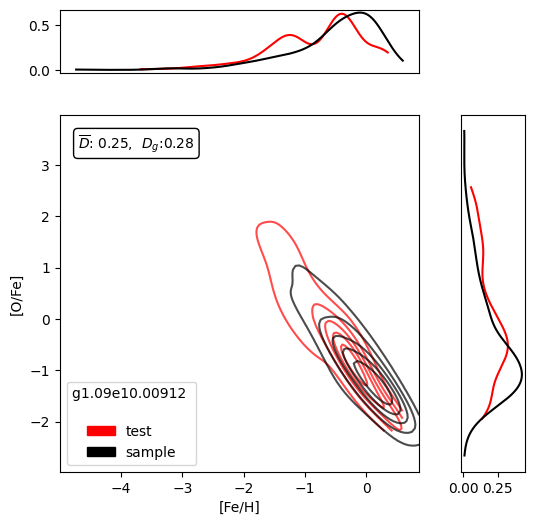

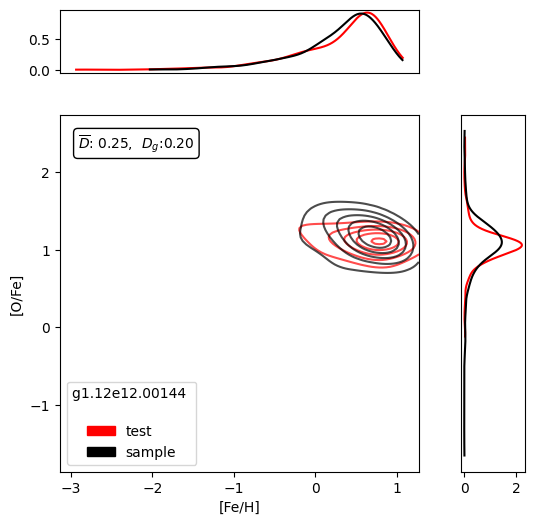

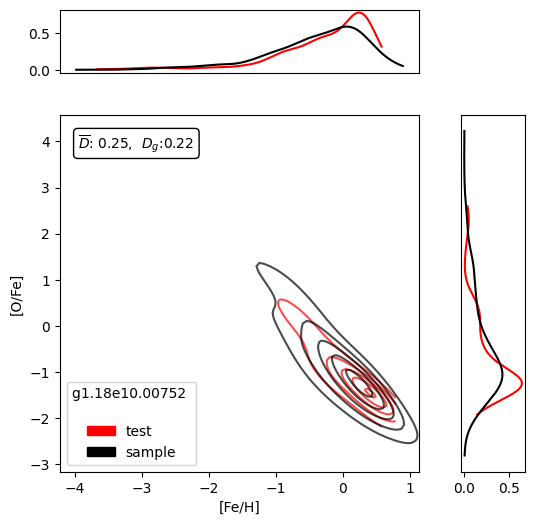

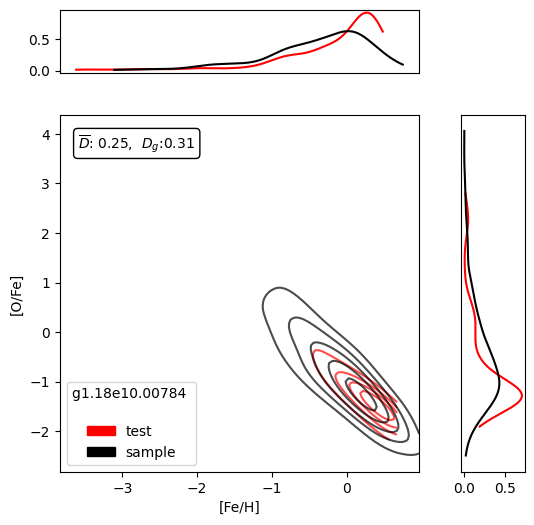

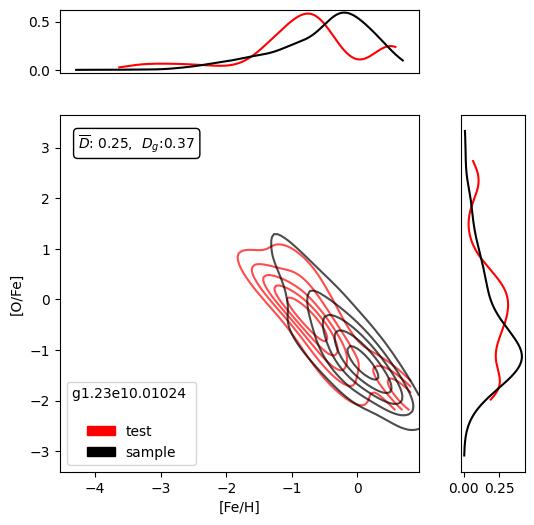

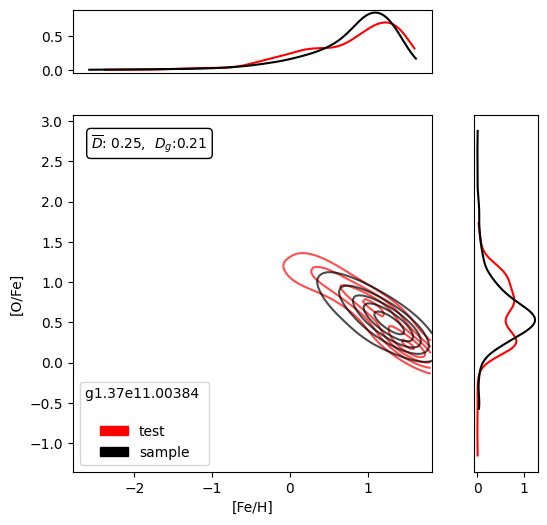

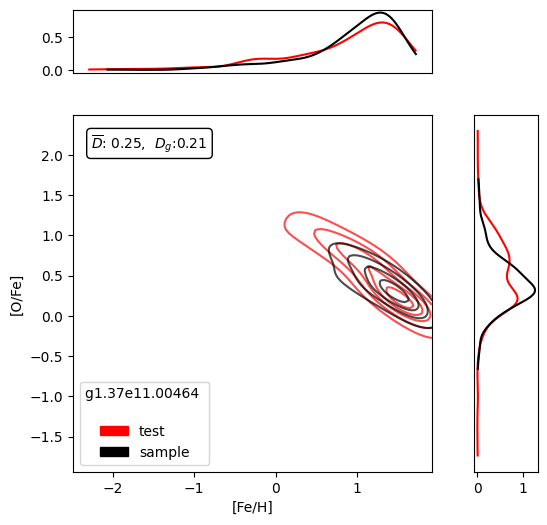

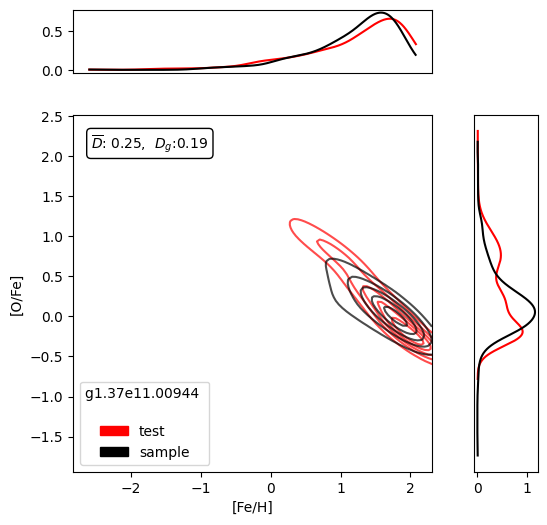

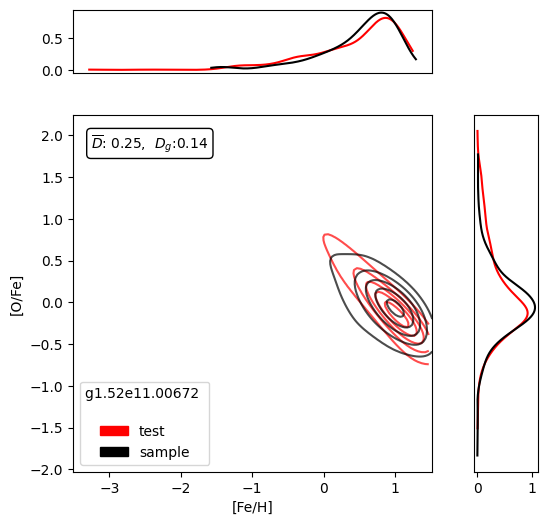

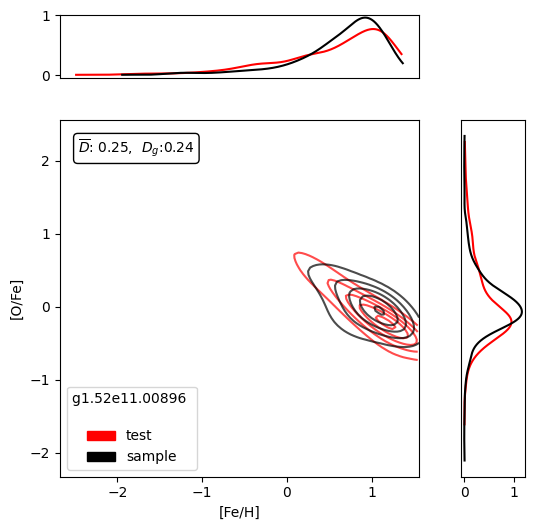

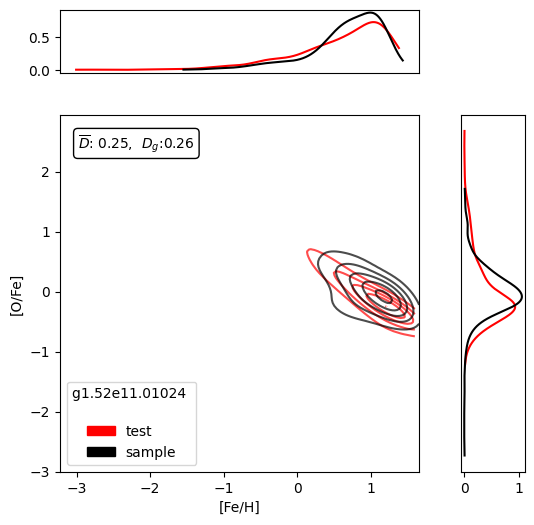

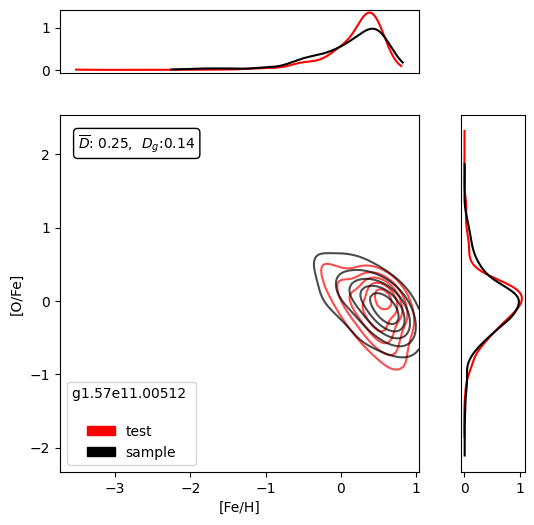

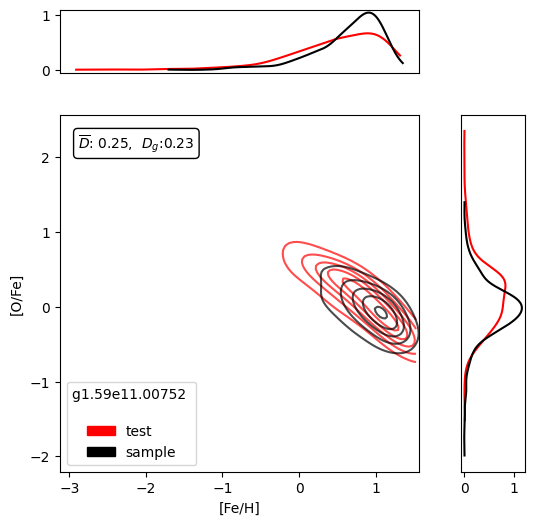

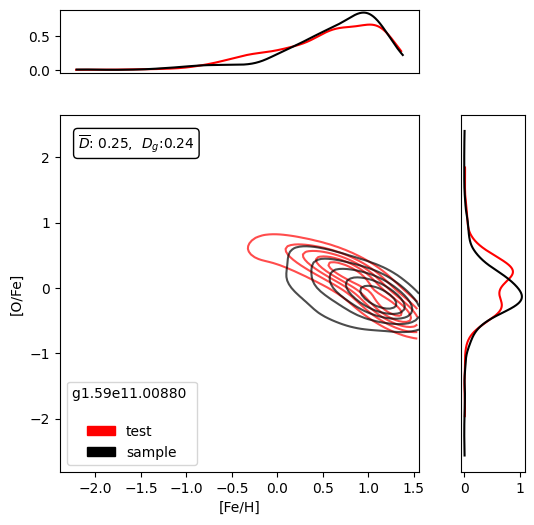

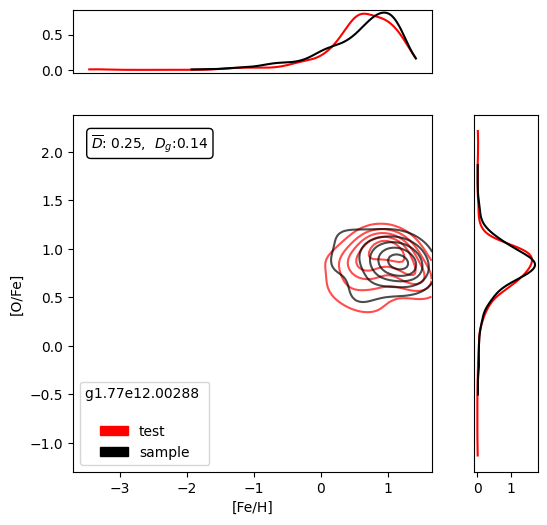

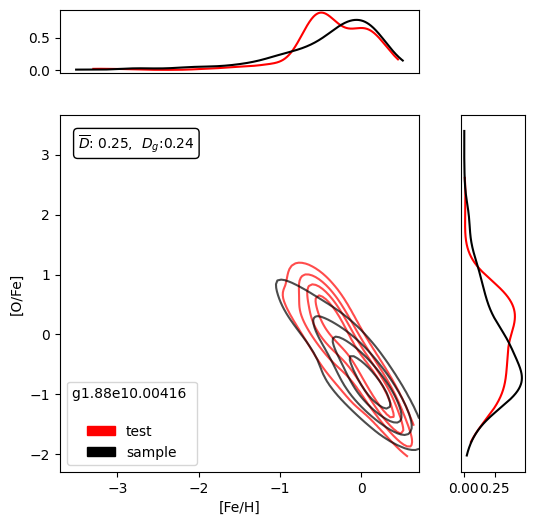

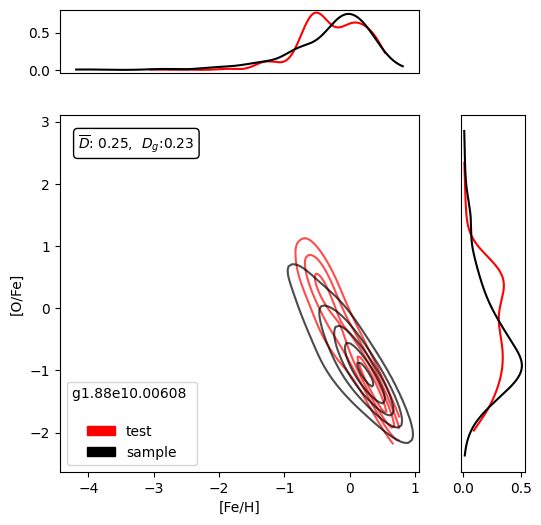

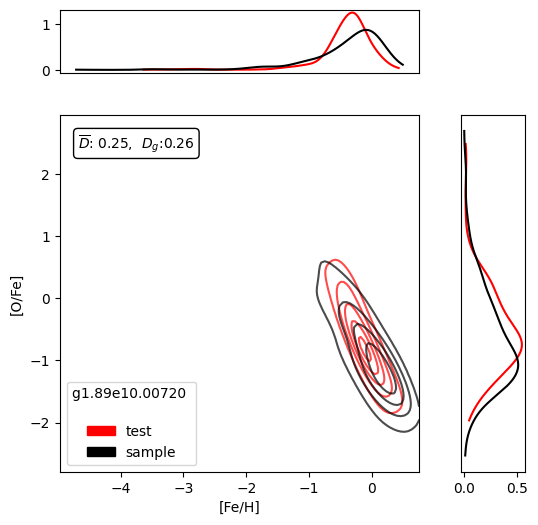

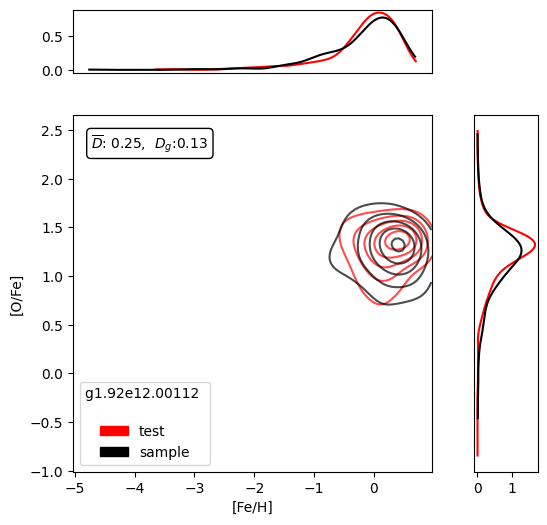

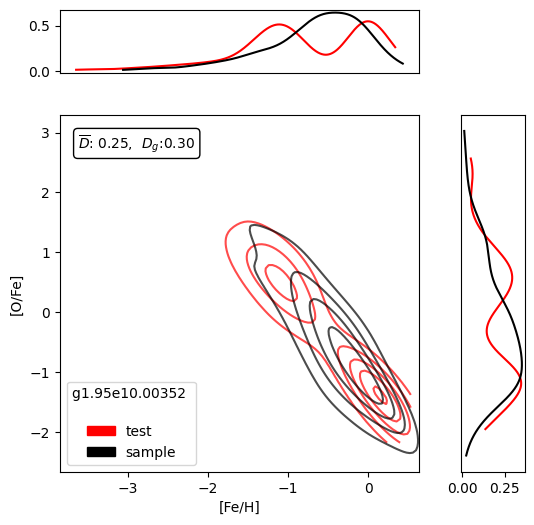

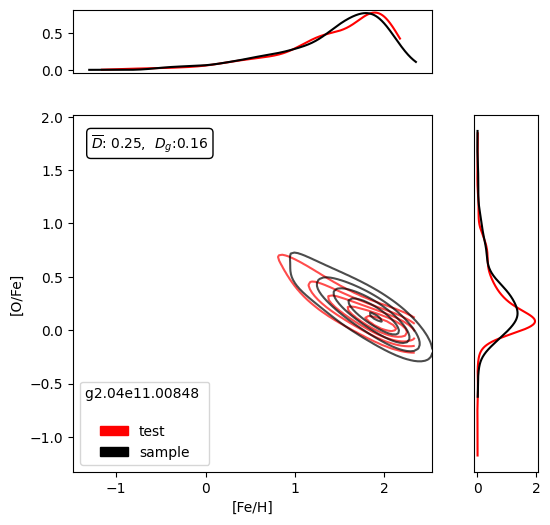

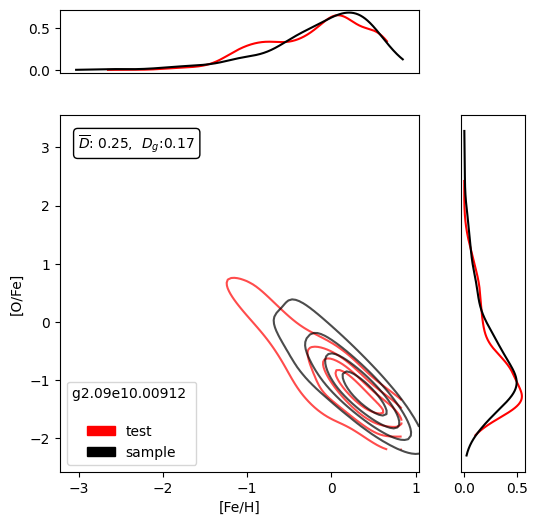

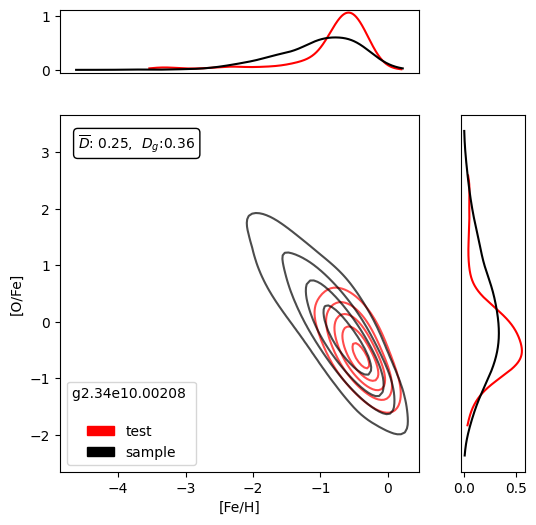

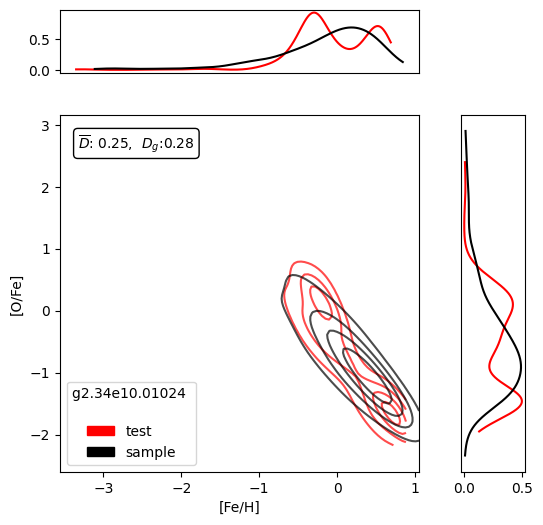

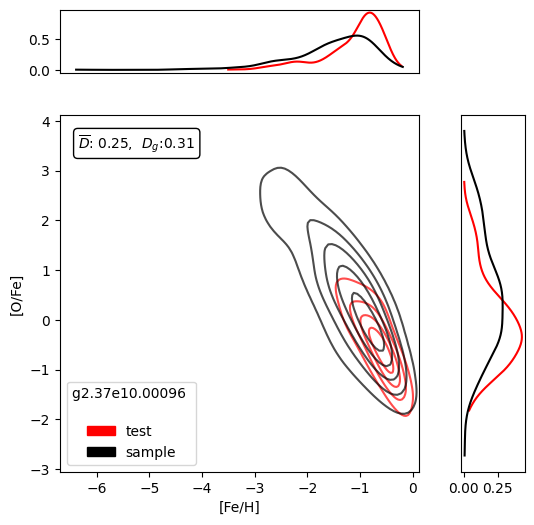

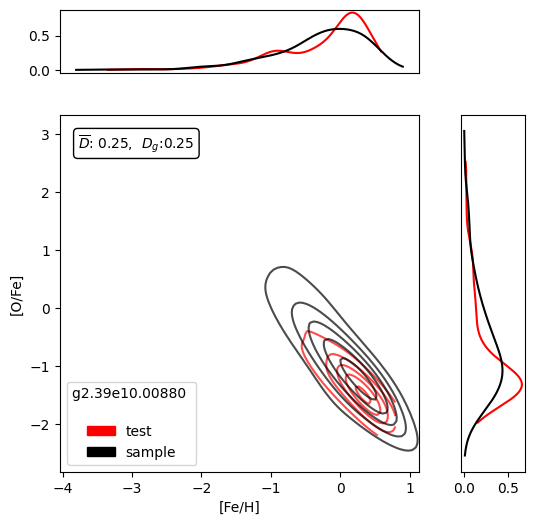

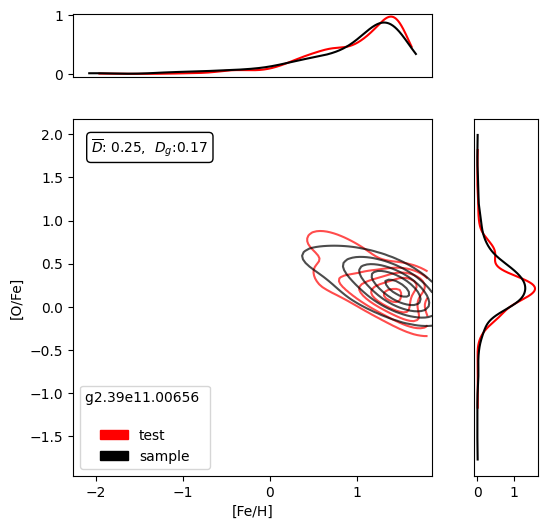

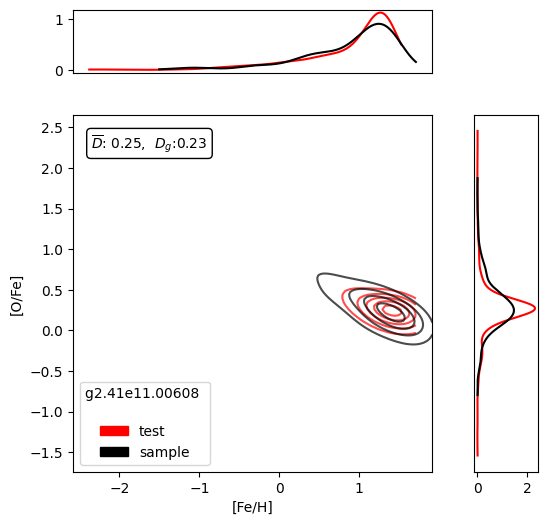

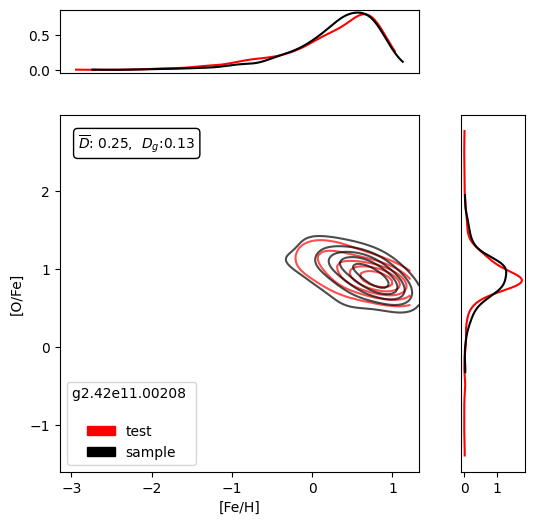

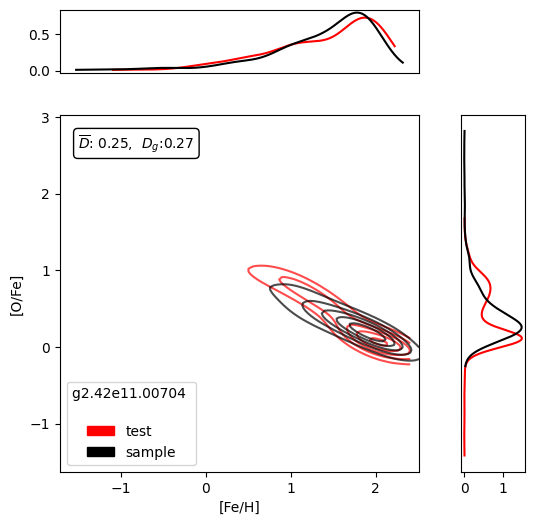

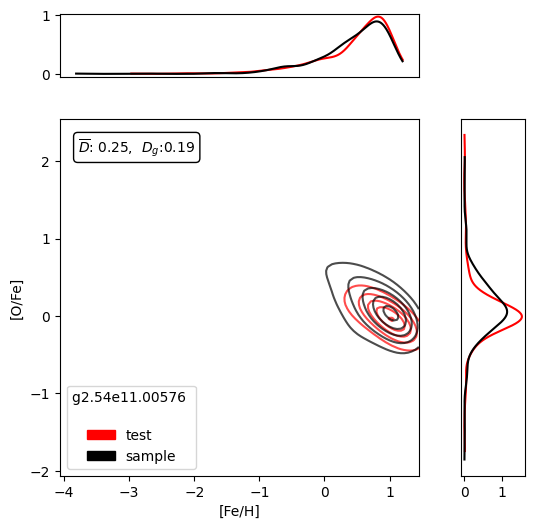

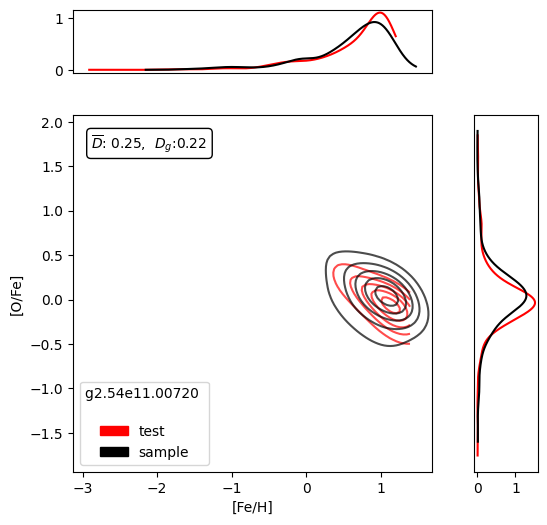

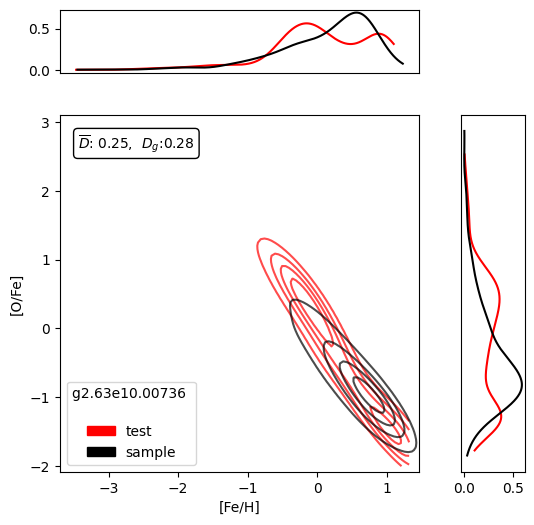

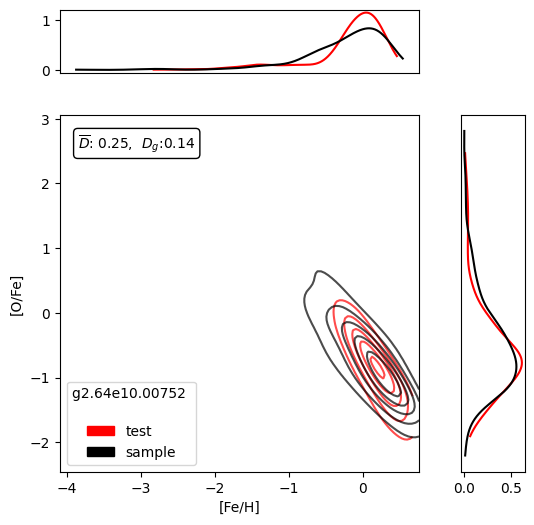

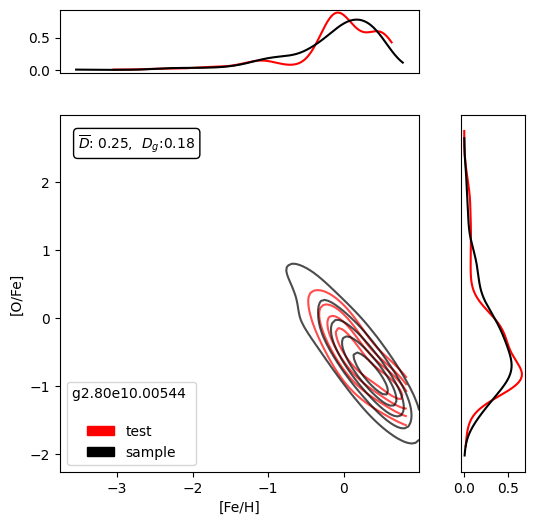

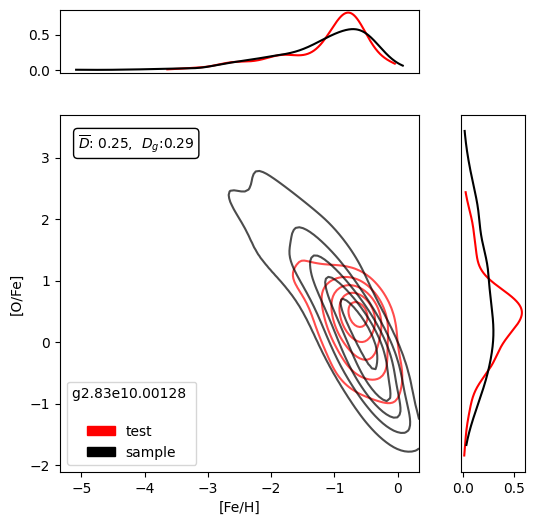

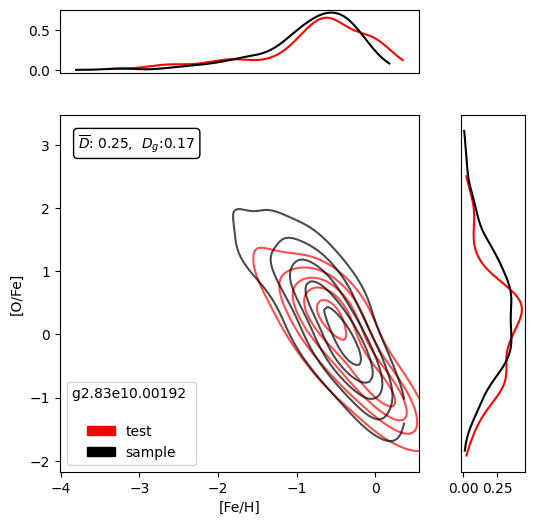

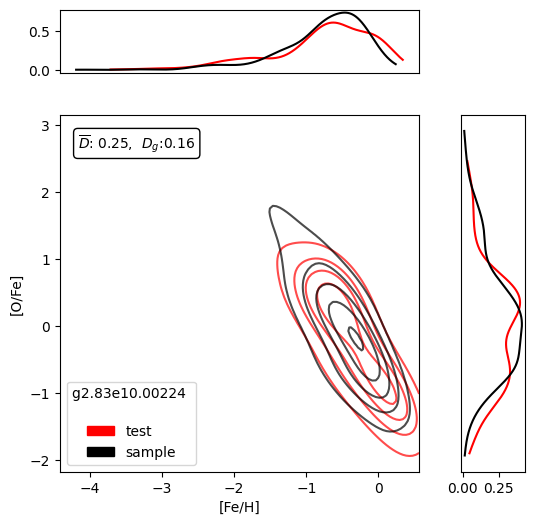

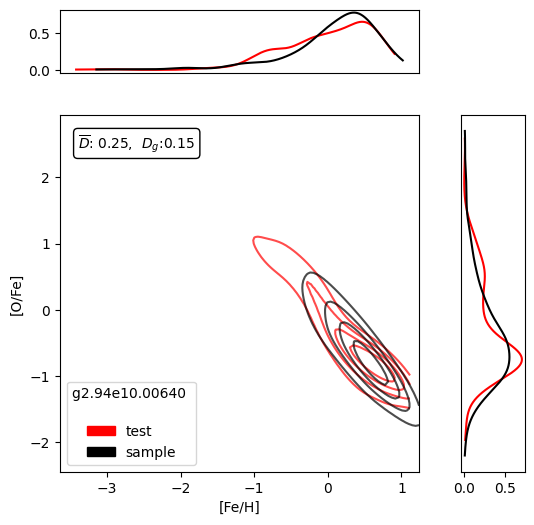

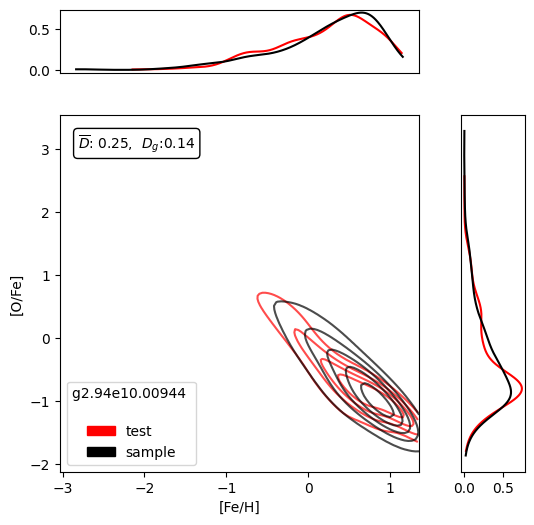

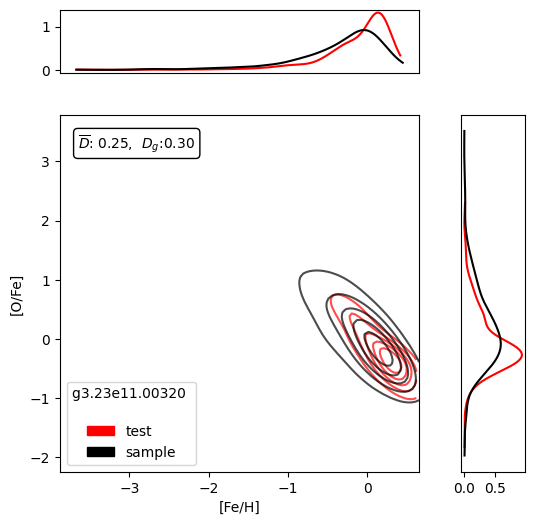

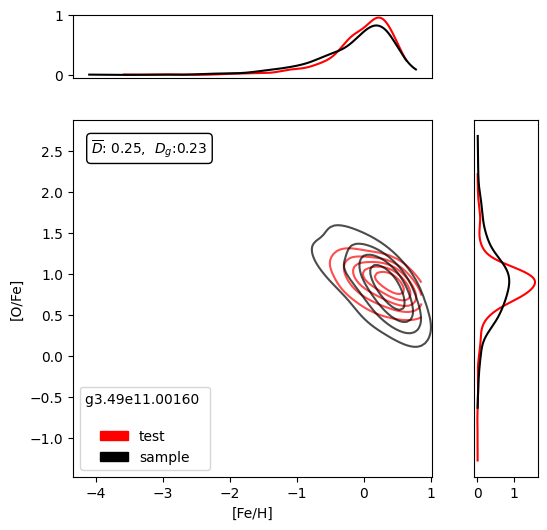

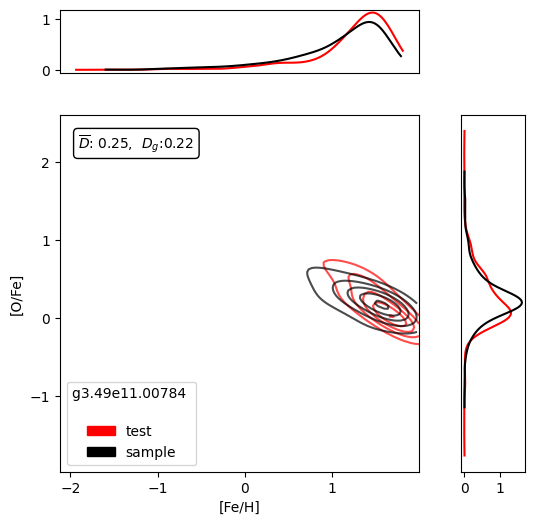

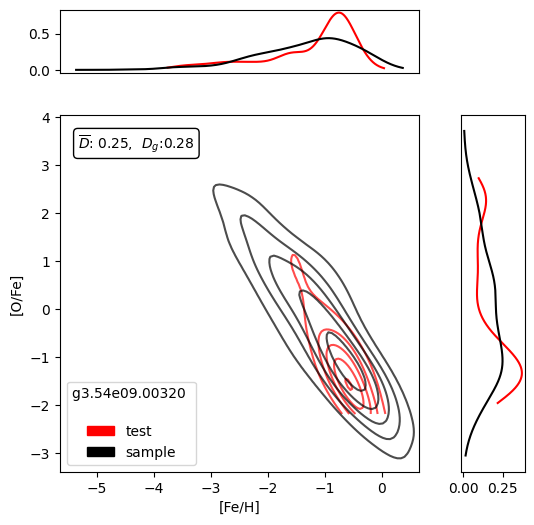

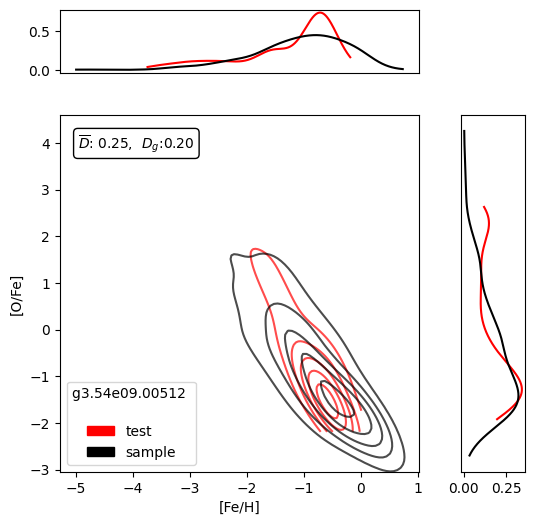

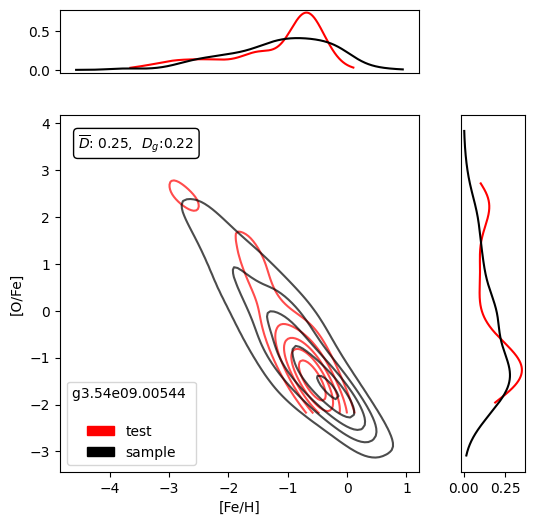

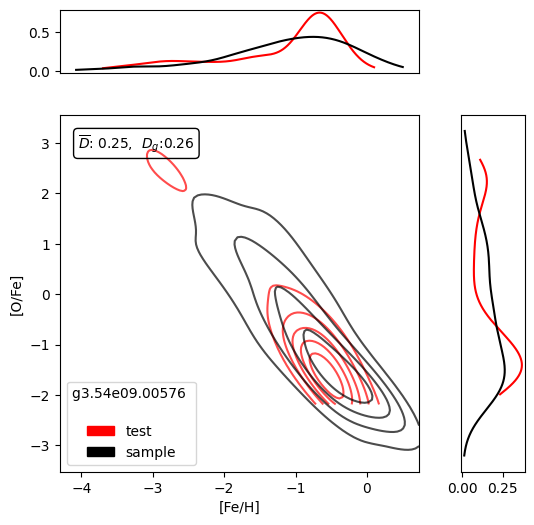

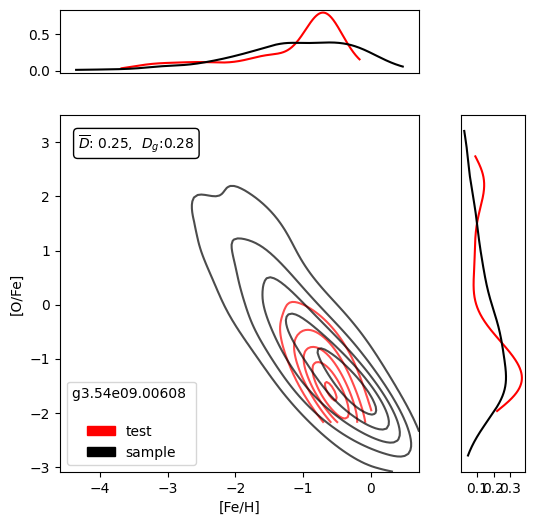

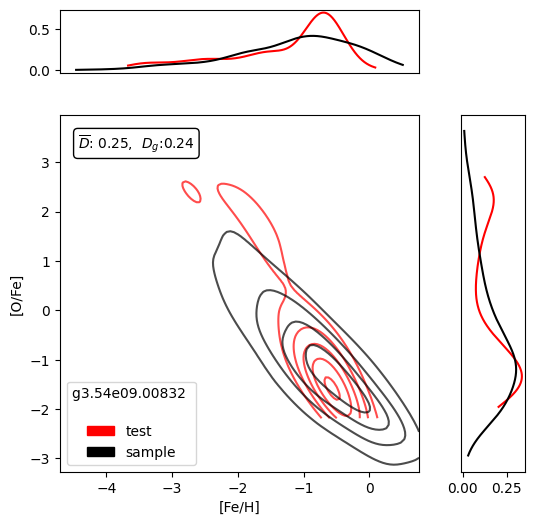

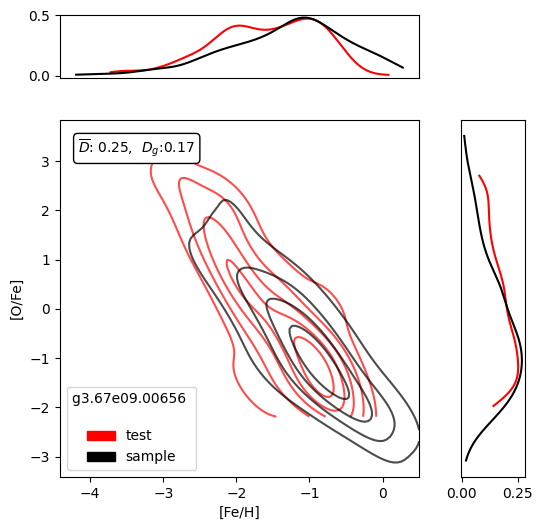

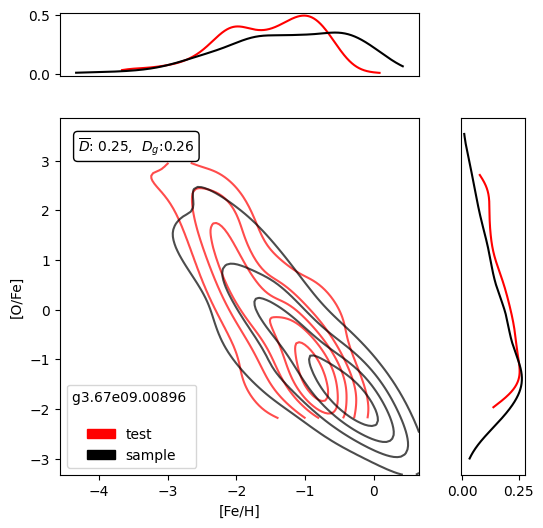

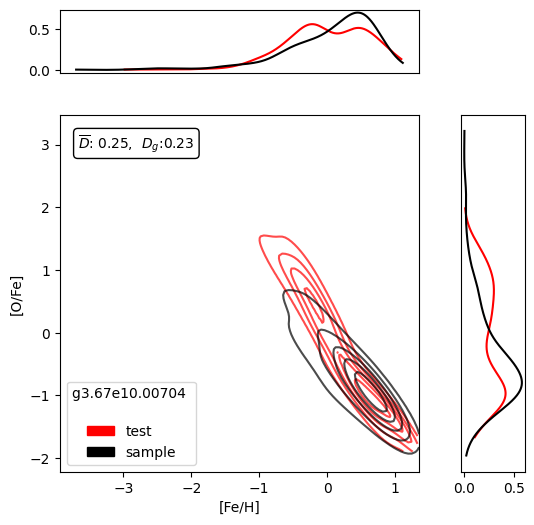

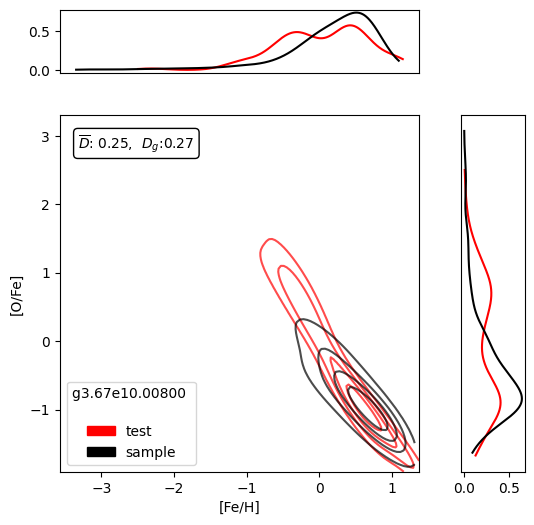

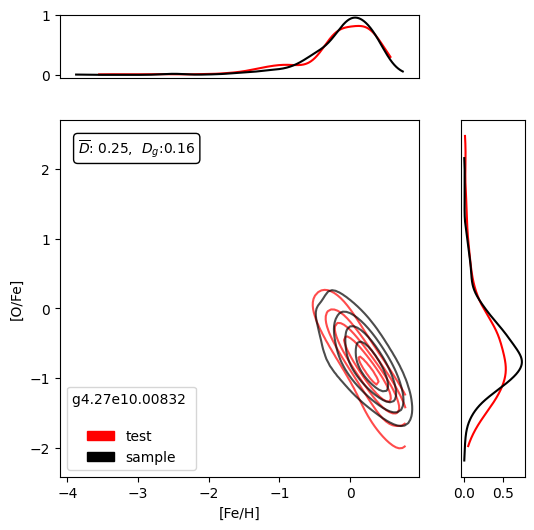

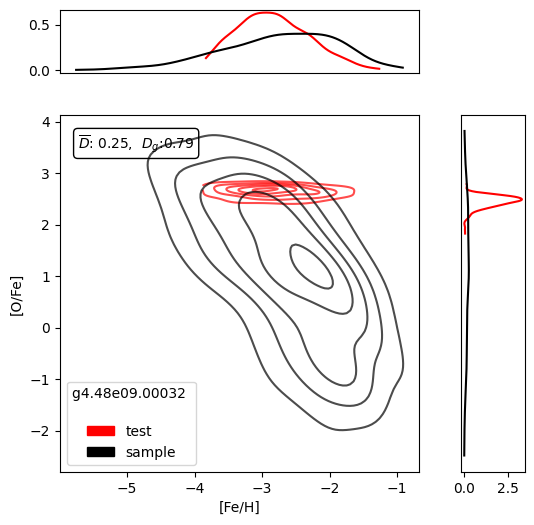

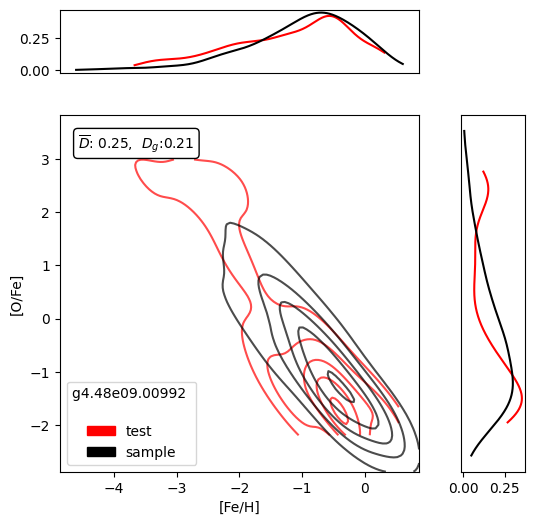

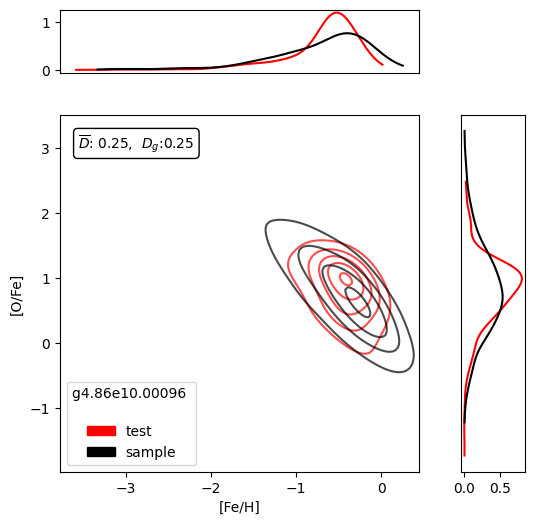

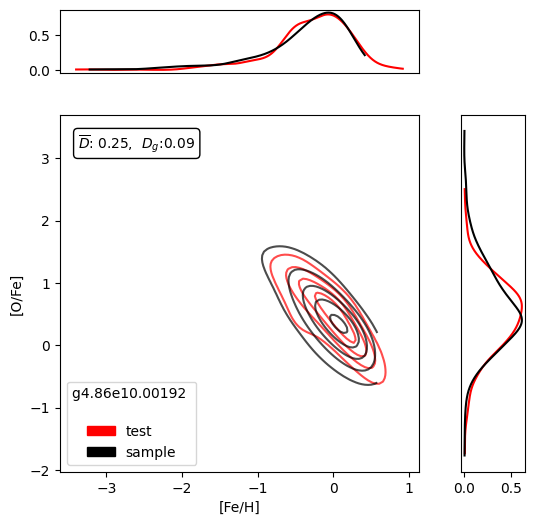

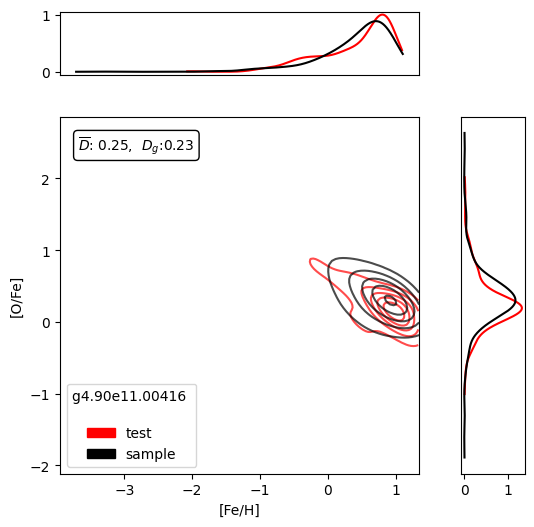

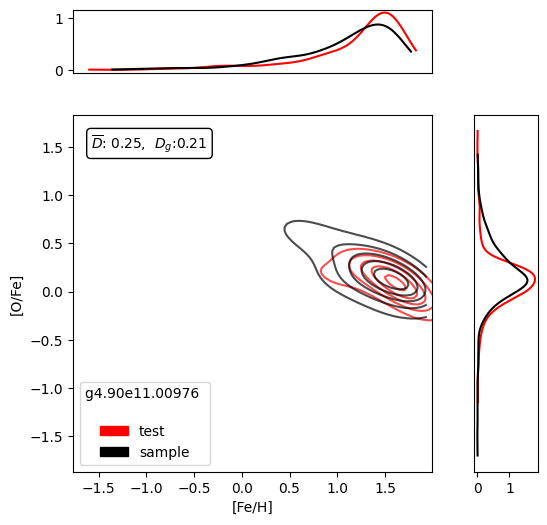

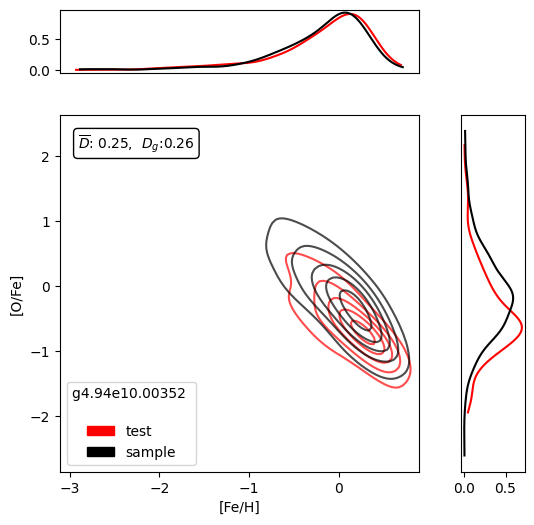

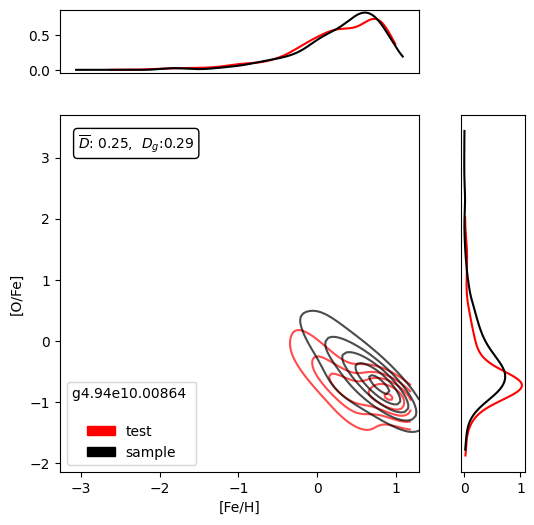

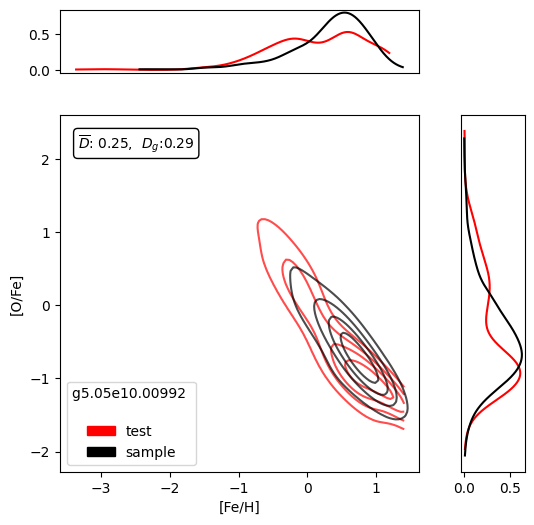

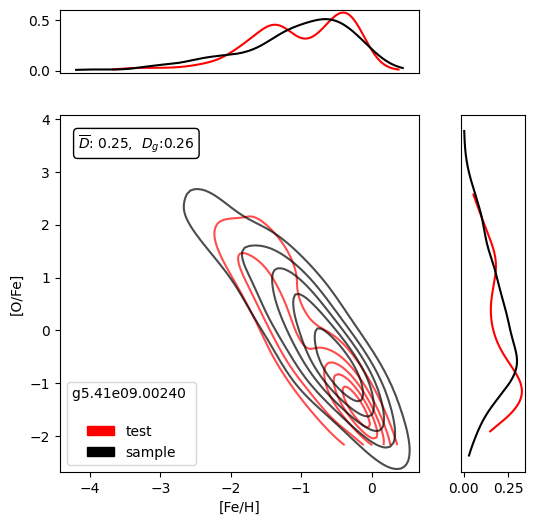

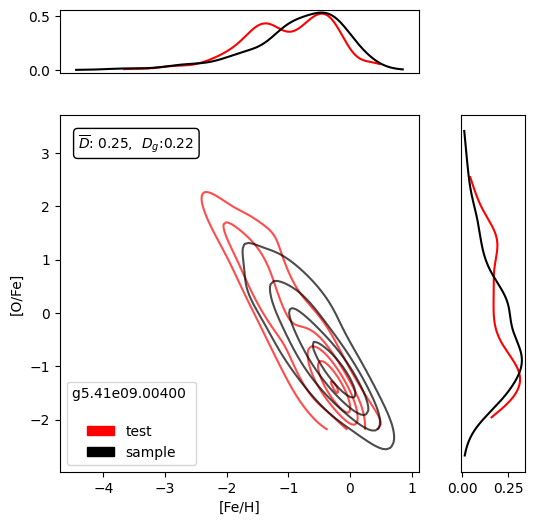

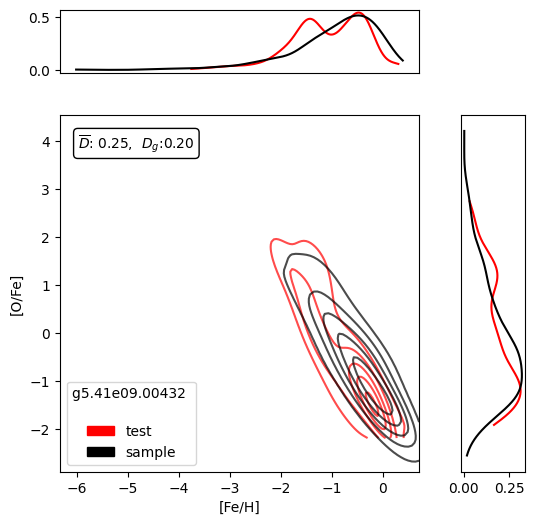

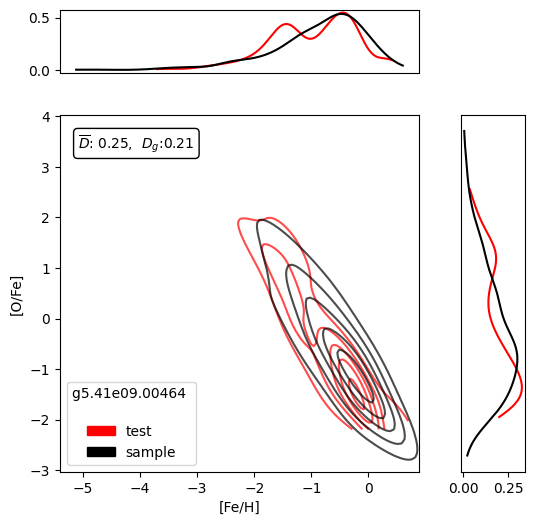

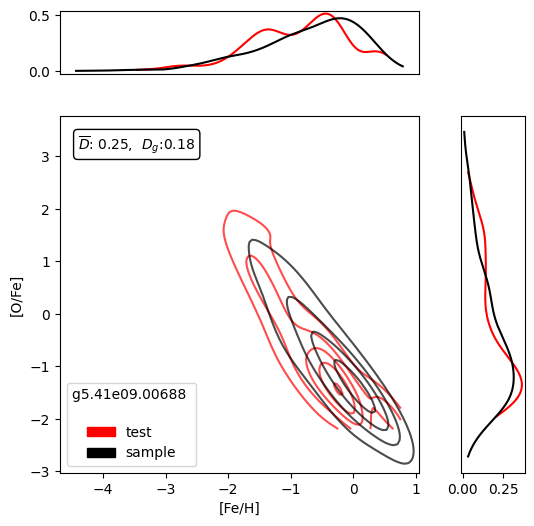

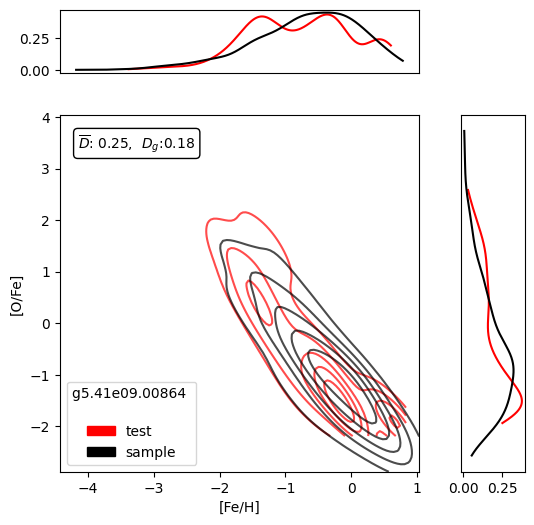

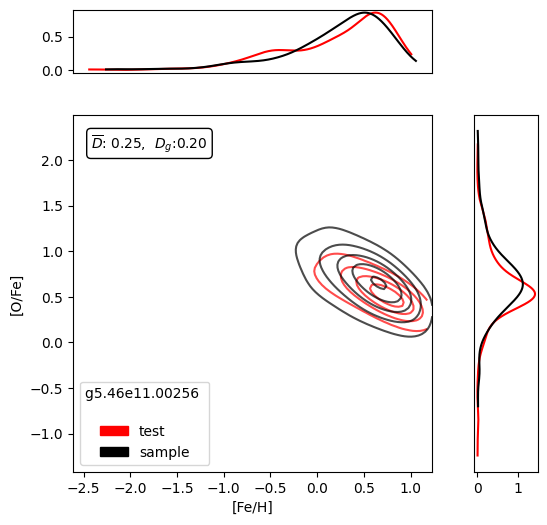

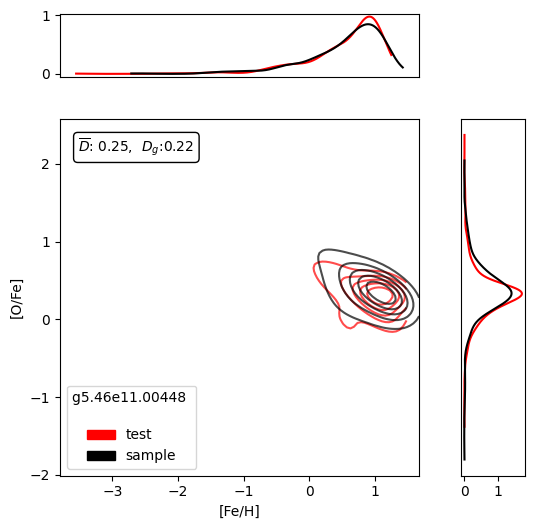

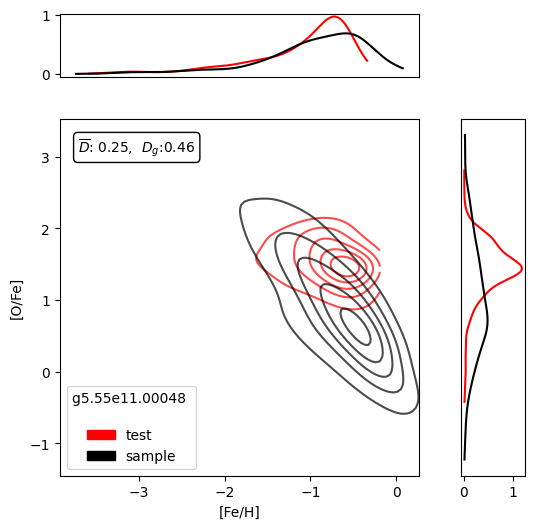

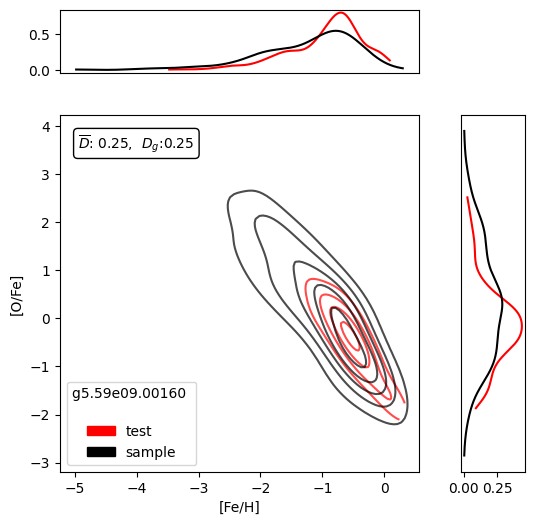

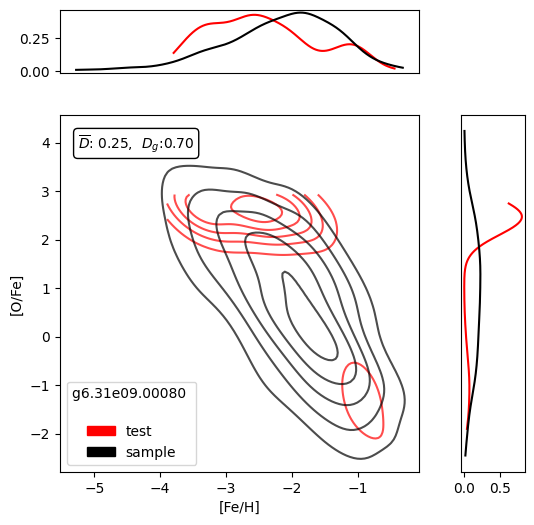

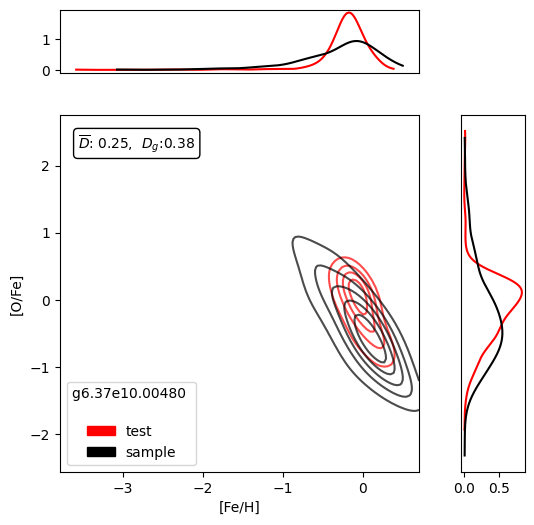

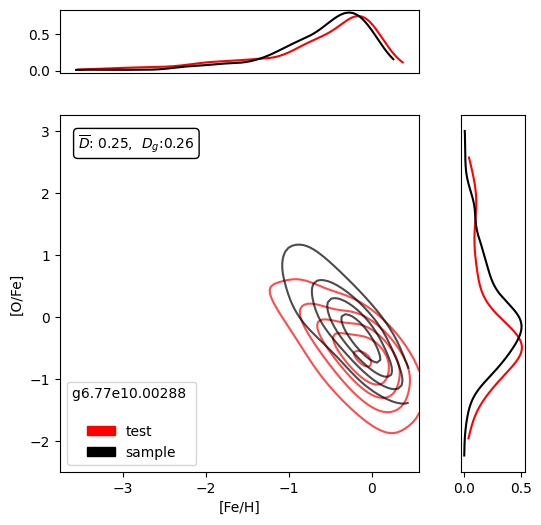

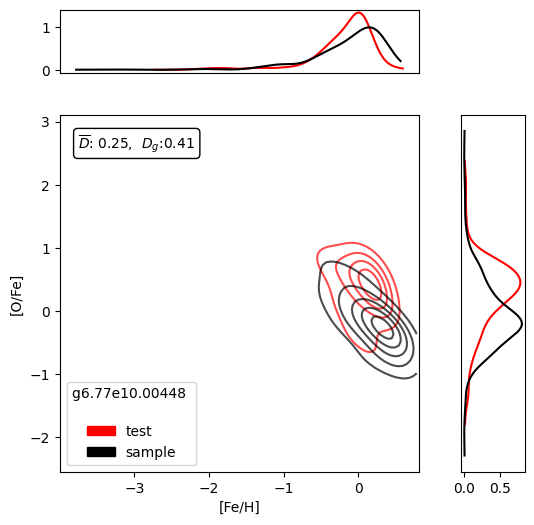

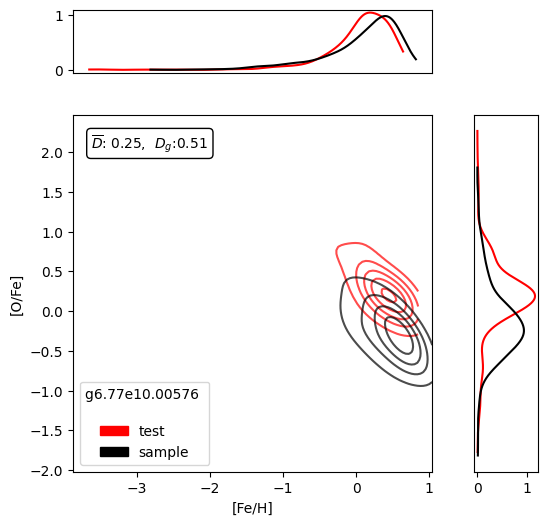

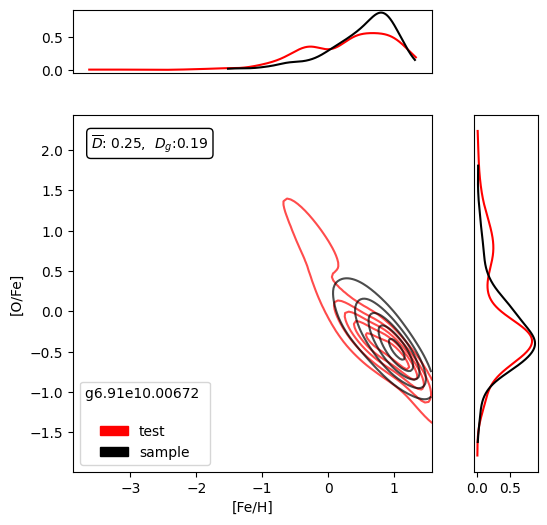

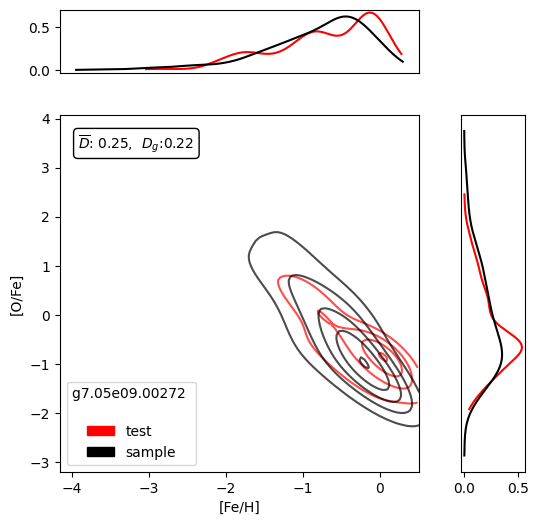

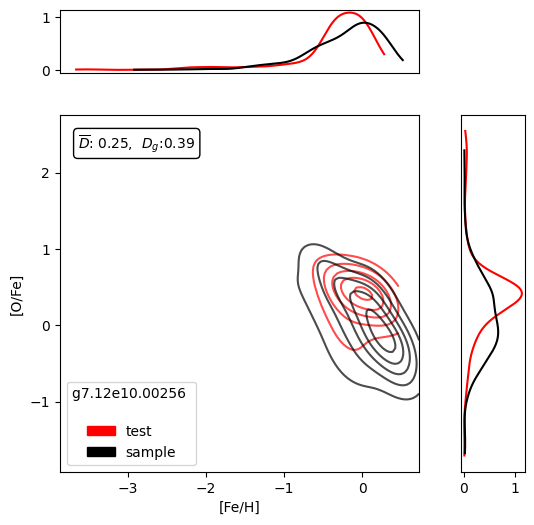

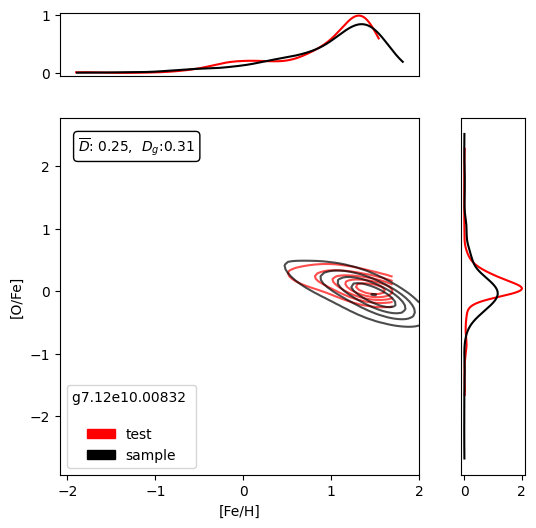

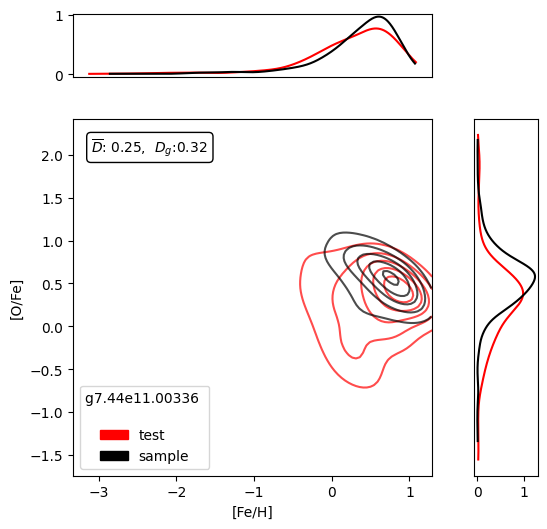

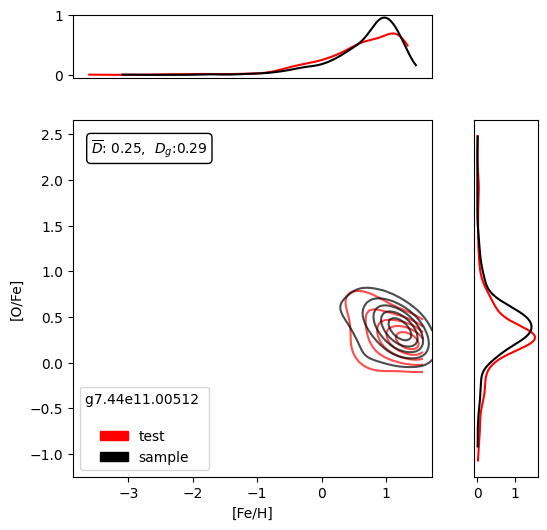

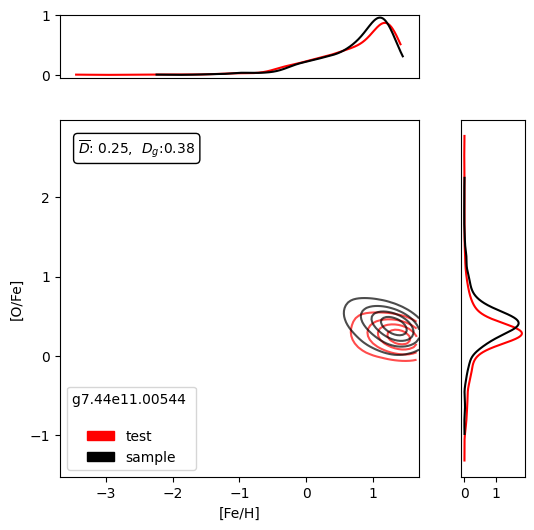

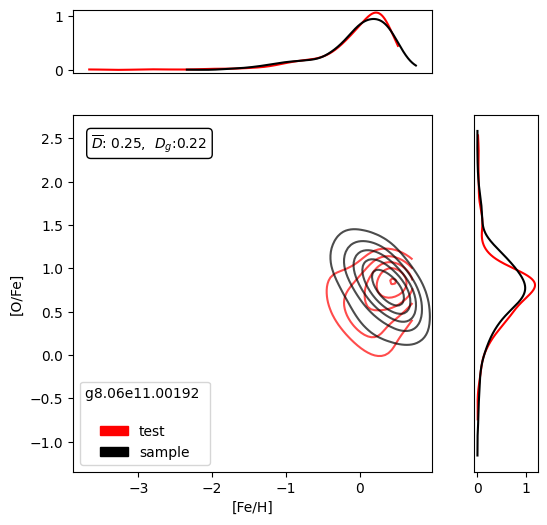

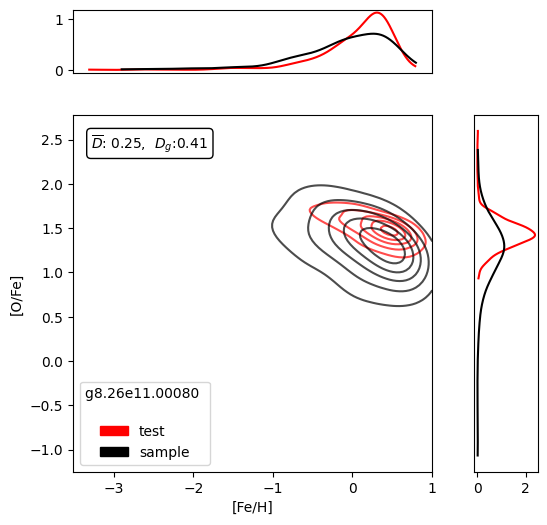

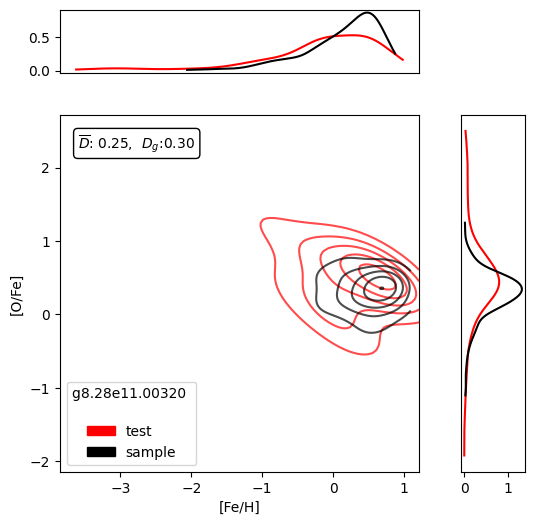

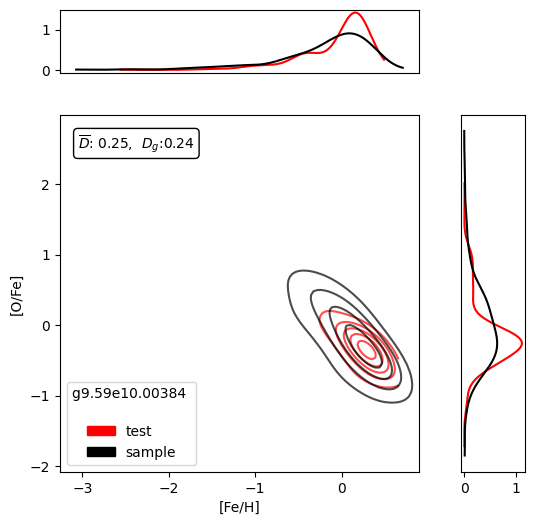

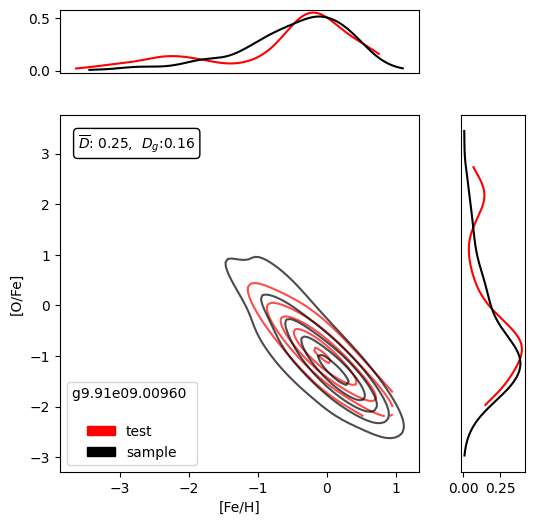

In [9]:
def custom_kde_plot(test_df: pd.DataFrame, df_sample, Flow, kl_mean: float, js_mean:float, D_mean:float, levels=5,):
    """
    
    
    
    """
    if 'Data' not in test_df.columns:
        test_df.insert(len(test_df.columns), 'Data', 'test')
    if 'Data' not in df_sample.columns:
        df_sample.insert(len(df_sample.columns), 'Data', 'sample')
    df_joinplot = pd.concat([test_df, df_sample])
    
    fig, ax = plt.subplots(2, 2, figsize=(6, 6), 
                        gridspec_kw={"height_ratios": (.15, .85), 
                                    "width_ratios": (.85, .15)})
    ax[0, 1].remove()

    colors = [['red'], ['black']]
    patches = []
    
    for i, data_type in enumerate(['test', 'sample']):
        # plot kde for data_type in ['simulation', 'generated']
        x = df_joinplot['feh'][df_joinplot['Data'] == data_type]
        y = df_joinplot['ofe'][df_joinplot['Data'] == data_type]
        
        if data_type == 'test':
            x_t = x
            y_t = y
            
        if data_type == 'sample':
            P, D_galaxy = ndtest.ks2d2s(x_t.to_numpy(), y_t.to_numpy(), x.to_numpy(), y.to_numpy(), extra=True)
    
        # Calculate 2D KDE
        kde = gaussian_kde(np.vstack([x, y]))

        # Create a grid of points for which to evaluate the KDE
        x_d = np.linspace(min(x), max(x), 100)
        y_d = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(x_d, y_d)
        Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))

        # Plot 2D KDE
        contour = ax[1, 0].contour(X, Y, Z.reshape(X.shape), levels=levels,  alpha=0.7, colors=colors[i])

        # Create a patch for the legend
        patches.append(mpatches.Patch(color=colors[i][0], label=data_type))
        
        # Calculate densities
        kde_x = gaussian_kde(x, )
        kde_y = gaussian_kde(y, )

        # Create an array of values for which to evaluate the KDE
        x_d = np.linspace(min(x), max(x), 1000)
        y_d = np.linspace(min(y), max(y), 1000)

        # Plot KDEs on the marginals
        ax[0, 0].plot(x_d, kde_x(x_d), color=colors[i][0])
        ax[1, 1].plot(kde_y(y_d), y_d, color=colors[i][0])

        # Remove labels from the marginal axes
        ax[0, 0].set_xticks([])
        ax[1, 1].set_yticks([])
        # ax[1, 0].text(ax[1,0].get_xlim()[0], 0.6, galaxy)
        

        # Set labels on the joint plot
        ax[1, 0].set_xlabel('[Fe/H]')
        ax[1, 0].set_ylabel('[O/Fe]')
        
        
        # Add the legend
        ax[1, 0].legend(title= f'{df_joinplot["Galaxy_name"].unique()[0]} \n', handles=patches, loc='lower left')
        if data_type == 'sample':
            text_to_show = f'$\overline{{D}}$: {D_mean:.2f},  $D_g$:{D_galaxy:.2f} '
            ax[1, 0].text(0.05, 0.95, text_to_show, verticalalignment='top', horizontalalignment='left', transform=ax[1, 0].transAxes, bbox=dict(boxstyle="round",facecolor='none'))

    test_df = test_df.drop(columns=['Data'])
    df_sample = df_sample.drop(columns=['Data'])

from matplotlib.backends.backend_pdf import PdfPages
# Create a new PDF file
pdf_pages = PdfPages('output.pdf')


for i, galaxy in enumerate(sorted(test_data['Galaxy_name'].unique())):
    test_data_galaxy = test_data[test_data['Galaxy_name']==galaxy]
    sample_data_galaxy = sample_df[sample_df['Galaxy_name']==galaxy]
    custom_kde_plot(test_data_galaxy, sample_data_galaxy, Flow, kl_div_mean, js_div_mean, D_mean, levels=5)
    pdf_pages.savefig()
    
# Close the PDF file
pdf_pages.close()